# Finetuning distilbert

In this activity, we will finetune a pre-trained BERT model.

The idea of fine tuning is that we will fit a classifier, as usual, but we will start with pre-trained weights.

The process for fine-tuning is the same as "fitting" a model, except that we avoid the cold-start problem. In this activity, we will use DistilBert, which is a smaller version of BERT.

In [1]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd

## Define a model

First, we define a classifier using BERT. Note that the classifier uses the CLS token's output as its own input. If you don't remember what the CLS token is, go back to the previous lesson.

In [2]:
class BertClassifier(nn.Module):
    def __init__(self, bert_model, num_classes, freeze_bert=False):
        super().__init__()
        self.bert = bert_model
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0, :]  # Use the CLS token's output
        logits = self.classifier(cls_token)
        return logits

Now, we load a dataset:

In [3]:
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd

train_df = pd.read_parquet("hf://datasets/stanfordnlp/imdb/plain_text/train-00000-of-00001.parquet").sample(50)
# Sample size is here so that our demo is faster


We will need a pre-trained tokenizer for distilbert:

In [4]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(list(train_df['text']), truncation=True, padding=True, return_tensors='pt')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [5]:
train_labels = torch.tensor(train_df['label'].tolist())


Now, note that we will need a `Dataset` and a `DataLoader`. The `Dataset` is a wrapper that allows sequentially retrieving items from our data. The `DataLoader` is another wrapper, which groups several items from a dataset into batches. Using them together allows us to avoid loading the whole dataset in our memory (which is useful when we have larger datasets).

In [6]:
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Now, note that we are going to be using an AdamW optimizer. AdamW builds on Adam by adding a regularization term, which prevents a phenomenon called "catastrophic forgetting". Catastrophic forgetting happens when the pre-trained model is fitted "too much" for fine tuning data, and the model starts losing its generalization capability.

In [7]:

model = BertClassifier(bert_model=bert, num_classes=2, freeze_bert=False).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)



Training goes on as usual...

In [8]:

def train(model, train_loader, optimizer, device):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(train_loader)


... but we save the final model after fine-tuning (so that we can retrieve it later!)

In [9]:
all_losses = []
for epoch in range(3):  # Train for some epochs...
    print(f"Epoch {epoch + 1}")
    loss = train(model, train_loader, optimizer, device)
    all_losses.append(loss)

torch.save(model.state_dict(), "distilbert.pth")

Epoch 1


100%|██████████| 13/13 [00:01<00:00, 12.05it/s]


Epoch 2


100%|██████████| 13/13 [00:00<00:00, 36.08it/s]


Epoch 3


100%|██████████| 13/13 [00:00<00:00, 35.97it/s]


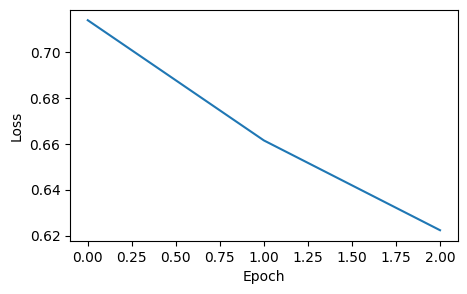

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))
plt.plot(all_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.savefig(f"distillbert_finetuning.pdf", bbox_inches='tight')
plt.show()

## Test the finetuned model

Ok, now we can test the finetuned model in the test set:

In [11]:
model.load_state_dict(torch.load("distilbert.pth"))

<All keys matched successfully>

In [12]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
test_df = pd.read_parquet("hf://datasets/stanfordnlp/imdb/plain_text/test-00000-of-00001.parquet")
test_encodings = tokenizer(list(test_df['text']), truncation=True, padding=True, return_tensors='pt')
test_labels = torch.tensor(test_df['label'].tolist())
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [13]:

model.eval()
all_predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids, attention_mask, labels_batch = [x.to(device) for x in batch]
        logits = model(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=1)
        all_predictions.append(preds.cpu())

all_predictions = torch.cat(all_predictions)

100%|██████████| 6250/6250 [00:42<00:00, 146.08it/s]


In [14]:
from sklearn.metrics import classification_report

# Assuming all_predictions and test_labels are defined
print(classification_report(test_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.59      0.84      0.69     12500
           1       0.72      0.41      0.52     12500

    accuracy                           0.63     25000
   macro avg       0.65      0.63      0.61     25000
weighted avg       0.65      0.63      0.61     25000



## Activity description

Make a learning curve for the fine-tuned DistillBERT. Represent the training dataset size in the x-axis. Represent the accuracy (or f1-score) in the y-axis. Run several training and testing evaluations. How does the learning curve behave, when compared to a bag-of-words model or to a single classifier trained from scratch? Also, how does it compare to fitting a classifier without changing the original BERT weights (that is, by keeping the BERT model frozen)? To show this, make a single plot with the four learning curves. Insert the figure in a PDF and submit it on Blackboard.

BONUS: run this same test on other datasets. Make a different plot for each one. What do you observe?